In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import os
import cv2

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten, Dense
from tensorflow.keras import Model

import warnings
warnings.filterwarnings("ignore")

In [2]:
os.chdir('data/1. open')

In [3]:
os.listdir()

['train_imgs.zip',
 'train_df.csv',
 'train_imgs',
 'test_imgs',
 'sample_submission.csv',
 'test_imgs.zip']

In [4]:
train=pd.read_csv('train_df.csv')
submission=pd.read_csv('sample_submission.csv')

train.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.48423,1020.117796,338.890539,1048.000000,...,1067.00000,335.0,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.59369,1041.422997,331.694815,1065.593682,...,1081.18738,323.0,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445


In [5]:
train.shape

(4195, 49)

In [6]:
submission.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,649-2-4-32-Z148_A-0000003.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
import glob
train_paths=sorted(glob.glob('./train_imgs/*.jpg'))
test_paths=sorted(glob.glob('./test_imgs/*.jpg'))
print(len(train_paths), len(test_paths))

4195 1600


## 시각화

In [8]:
train_paths.sort()

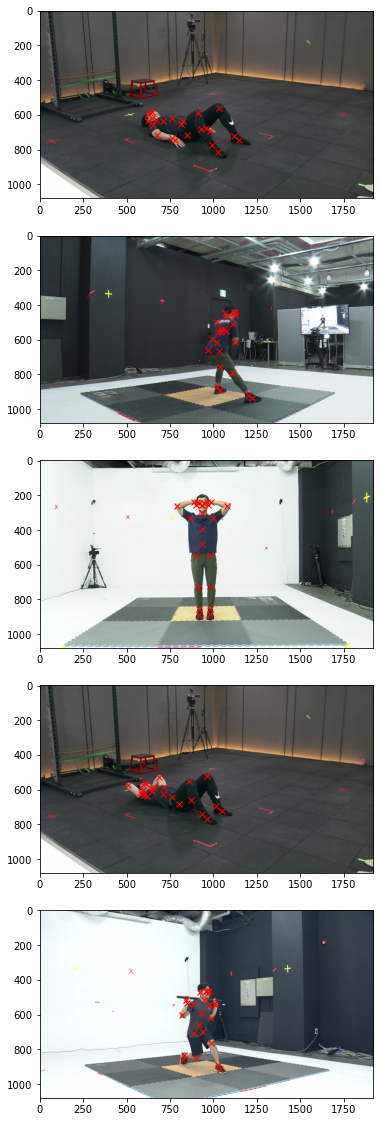

In [9]:
plt.figure(figsize=(40,20))
count = 1

for i in np.random.randint(0, len(train_paths), 5):
    plt.subplot(5, 1, count)
    
    img_sample_path = train_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)
    
    keypoint = train.iloc[:,1:49]
    keypoint_sample = keypoint.iloc[i,:]
    
    for j in range(0, len(keypoint.columns), 2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1], 'rx')
        plt.imshow(img_np)
        
    count += 1

## 모델링

In [10]:
train['path'] = train_paths

In [35]:
def trainGenerator():
    for i in range(len(train)):
        img = tf.io.read_file(train['path'][i])
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [180, 320])
        target = train.iloc[:, 1:49].iloc[i,:]
        
        yield (img, target)
        
#generator를 활용해 데이터셋 만들기?
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([180,320,3]),tf.TensorShape([48])))
train_dataset = train_dataset.batch(32).prefetch(1)

In [12]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

In [26]:
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(180,320,3)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(48))

In [29]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

In [36]:
model.fit(train_dataset, epochs = 5, verbose=1)

Epoch 1/5
132/132 [==============================] - 80s 538ms/step - loss: 35178.2812 - mae: 130.4179
Epoch 2/5
132/132 [==============================] - 64s 481ms/step - loss: 14848.6094 - mae: 92.4789
Epoch 3/5
132/132 [==============================] - 62s 472ms/step - loss: 12636.5391 - mae: 85.0127
Epoch 4/5
132/132 [==============================] - 61s 465ms/step - loss: 14223.2949 - mae: 91.0273
Epoch 5/5
132/132 [==============================] - 61s 463ms/step - loss: 13483.3154 - mae: 88.1221


## test 데이터


In [38]:
X_test = []

for test_path in tqdm(test_paths):
    img=tf.io.read_file(test_path)
    img=tf.image.decode_jpeg(img, channels=3)
    img=tf.image.resize(img, [180,320])
    X_test.append(img)

100%|██████████| 1600/1600 [00:14<00:00, 109.38it/s]


In [39]:
X_test=tf.stack(X_test, axis=0)
X_test.shape

TensorShape([1600, 180, 320, 3])

In [40]:
pred=model.predict(X_test)

## 제출하기

In [41]:
submission.iloc[:, 1:]=pred

In [42]:
submission

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,1276.997559,553.833008,1236.588867,605.546814,1277.832275,549.387695,1207.295898,638.630981,1220.205322,...,1260.219238,418.660217,1046.062988,582.642761,900.858948,584.727844,562.960388,696.480835,727.484985,742.659912
1,649-2-4-32-Z148_A-0000003.jpg,1274.849365,555.412354,1235.329834,606.671936,1276.219971,551.013489,1205.807007,639.863159,1218.959839,...,1258.832520,419.909302,1044.950195,583.412476,899.783264,585.139648,562.594116,695.768372,726.878662,742.395874
2,649-2-4-32-Z148_A-0000005.jpg,1285.666138,562.614075,1243.830078,610.746277,1284.249268,558.835938,1213.072632,641.026978,1227.935913,...,1270.987793,426.478119,1050.640747,584.999878,904.487549,586.610718,561.578918,693.655884,732.640625,742.382996
3,649-2-4-32-Z148_A-0000007.jpg,1310.385254,596.989258,1264.693726,652.618774,1303.555176,606.398865,1239.249878,685.073975,1248.503784,...,1290.274658,453.248779,1078.816040,606.609192,928.363647,623.379150,587.653320,716.663696,746.214966,771.843018
4,649-2-4-32-Z148_A-0000009.jpg,1297.731689,585.798645,1263.678101,631.661499,1298.472656,578.814331,1231.339722,660.763916,1243.731689,...,1286.358887,453.795685,1063.743774,602.217773,916.898682,606.926147,569.398926,696.803345,735.265930,756.314331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,786-3-5-41-Z94_E-0000023.jpg,741.478760,482.987457,699.349121,558.496582,763.356628,446.619751,811.998657,578.703613,731.252686,...,917.770508,383.309998,844.817627,600.211975,879.412231,657.454285,872.883301,704.338623,1062.955688,757.229797
1596,786-3-5-41-Z94_E-0000025.jpg,839.300415,513.797424,772.008850,601.890442,839.730469,480.296021,877.321899,625.753052,800.920227,...,981.245117,391.363953,916.872681,638.610901,927.615540,700.504639,914.266541,705.080322,1111.251465,758.259033
1597,786-3-5-41-Z94_E-0000027.jpg,742.838745,478.788574,700.103699,554.553833,765.369690,444.721191,814.645813,578.437622,731.999146,...,917.172363,377.723267,846.977905,602.563171,879.514282,662.411194,875.089905,699.586426,1066.629028,749.592102
1598,786-3-5-41-Z94_E-0000029.jpg,797.012756,507.810120,744.521851,590.390076,808.906555,469.943726,854.073425,615.805664,771.296997,...,954.081909,395.412048,887.414673,633.597656,911.308716,696.238525,900.560059,703.571777,1093.680176,758.852905


In [43]:
submission.to_csv('baseline_submission.csv', index=False)